In [1]:
import pandas as pd
import numpy as np
from plotly_dataframe import plot 
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from model_selection import rolling_window_validation
from kNN_TSPI import kNN_TSPI
from metrics import metrics
import os
import shutil
from plotly_plt_predictions import plot_predictions
from tqdm import tqdm
from ipywidgets import widgets, interact
import matplotlib.pyplot as plt
from plot_map import choropleth
from IPython.display import clear_output, display

# Forecasting - Food Consumption Score (FCS)

In [4]:
# Load the original data (smoothed data) of the second version of fcs indicator released by wfp.
df = pd.read_csv("../../../Data Sources/Food Consumption Score (FCS)/time-series/Yemen/wfp_fcs-v2-daily-interpolate.csv", header = [0, 1], index_col = 0)
df.index.name = "Datetime"
df.index = pd.to_datetime(df.index)
freq = "D"
df.index.freq = freq
df.columns.names = ["AdminStrata", "Indicator"]
df.head()

AdminStrata,Abyan,Aden,Al Bayda,Al Dhale'e,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amanat Al Asimah,Amran,...,Hadramaut,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'ada,Sana'a,Shabwah,Taizz
Indicator,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,...,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-02,31.158690,16.619519,38.332669,29.194825,20.788151,22.085706,2.892308,16.815145,17.000398,20.446735,...,23.822825,28.361345,25.036668,31.762436,32.596233,54.121774,17.676022,26.917713,16.752289,26.563365
2018-07-03,32.675222,16.370603,43.292084,31.336940,20.692544,23.477196,2.913825,19.833443,17.208166,21.689014,...,23.699881,28.805448,27.102390,32.049499,33.333333,56.722689,17.134560,25.783476,18.257453,29.124005
2018-07-04,33.415597,15.089163,45.128205,33.135157,21.825051,24.864000,2.950408,19.614289,18.070801,25.611124,...,23.103187,30.993706,29.844066,33.106267,36.883683,56.306306,17.454545,25.436047,19.083081,29.427973
2018-07-05,33.531451,15.766521,43.959297,34.554309,21.481693,27.814992,2.247913,19.558566,19.021964,27.922484,...,21.596419,32.905902,29.025363,32.938828,36.897633,56.231003,17.846350,27.421759,20.349533,30.456026
2018-07-06,33.951856,16.870065,44.516521,33.878557,21.076712,28.688245,2.269780,17.608130,19.817567,28.712235,...,20.129084,32.598181,30.692766,33.837934,36.669568,57.324841,18.463057,26.547231,21.107524,31.012517


In [5]:
#plot(fcs, title = "FCS indicator", yaxis = "% of people with poor and borderline FCS", style = "lines")

In [6]:
# Define the desired length of the test set.
TEST = 30
# Define the metric to evaluate the model.
ERROR = "MSE"
# Set boolean parameter to perform an optional grid search.
GRID_SEARCH = True

In [7]:
# Define the training set and the test set.
train = df[:-TEST]  
test = df[-TEST:]

In [8]:
# Create workspace.
dir = "./output"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)           
    os.makedirs(dir)
    
os.makedirs(dir + "/images")
os.makedirs(dir + "/grid_search")

# Create a txt file where I annotate the above chosen parameters.
with open(dir + "/setting.txt", "w") as f:
    f.write("GRID SEARCH: %s \n" % GRID_SEARCH)
    f.write("TEST: %d \n" % TEST)
    f.write("ERROR: %s \n" % ERROR)

# kNN-TSPI model

Similarity-based methods, like the kNN classifier, are characterized by not constructing a model that explicity describes the training dataset behaviuor. The kNN is an instance-based Machine Learning algorithm that consists on finding, according to some similarity measure, the k examples that are the nearest to an unlabeled example. The new example classification is decided on the labels of those k nearest examples. The model is built by simply storing the data sample. Given a time-series $Z = \{z_1, z_2, ..., z_m\}$, let's suppose to want to predict the next $z_{m + 1}$ value. The general and the basic idea behind the adaptation of kNN for time-series prediction is very intuitive: the method uses the last $l$ observations of the time-series as query $Q$, and search for the most similar subsequence to $Q$, using a sliding window of size $l$. Given $S_l^{(1)} ... S_l^{(k)}$ as the $k$ most similar (using a specific criterion; in our case the complexity invariant distance) subsequences of $Q$, the algorithm uses the next observations of each subsequences $S_{l+1}^{(j)}$ with $1 \le j \le k$ to predict the $z_{m + 1}$ value. Thereby, the values of $S_{l+1}^{(j)}$ are provided as input to a prediction function $f$ to approximate the value $z_{m + 1}$. An example of ensemble function is:

$$f(S) = \frac{1}{k} \sum_{j = 1}^{k} S_{l+1}^{(j)}$$

This is the simplest way of combining the projections since the predictions average considers that all projected values are equally probable to occur in the future. The prediction made by similarity-based methods considers only the previous $l$ observations. Thus, the temporal dependence is restricted to a limited number of previous observations, since usually a certain value is not influenced by observations that happened a long time ago.

Several surveys were conducted to analyze the performance of the presented method with different prediction functions and various distance measures. In the paper "**A Study of the Use of Complexity Measures in the Similarity Search Process Adopted by kNN Algorithm for Time Series Prediction**" demonstrates that the right combination of amplitude, offset and recently proposed complexity invariance, combined with a policy to avoid trivial matches, leads to more precise and meaningful predictions.

# Optional grid search

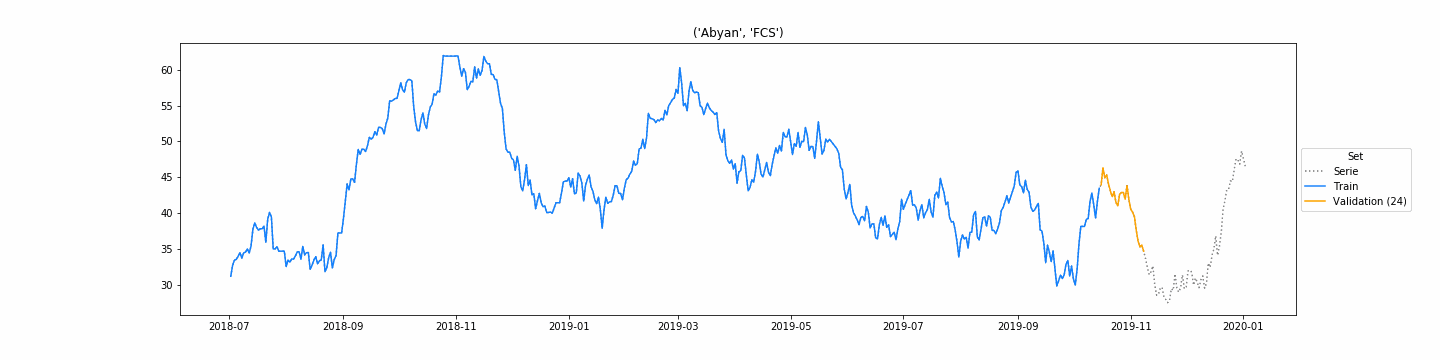

In [9]:
# Define the parameters to grid search.
if GRID_SEARCH:
    validation_type = rolling_window_validation(k_folds = 3, validation_size = 0.05, gap = 0.9, TimeSeriesSplit = False)
    # Show the validation type keeping the first column (time-series).
    _ = validation_type.get_splits(train[train.columns[0]], show = True, path = dir)
    space = {"l": hp.randint("l", 3, 30), 
             "k": hp.randint("k", 1, 10), 
             "complexity_measure": hp.choice("complexity_measure", ["squared difference"])
            }
else:
    space = {"l": 10,
             "k": 4,
             "complexity_measure": "squared difference"
            }

In [10]:
def hyperparameters(space, group):
    adminstrata = group.name
    try:
        losses = list()
        for tr, val in validation_type.get_splits(group, show = False):  
            # Define model.
            model = kNN_TSPI(l = int(space["l"]), k = int(space["k"]), complexity_measure = space["complexity_measure"], h = len(val))
            # Coumpute prediction on this fold.
            pred = model.predict(tr)
            error = metrics(val, pred, ERROR).compute()
            losses.append(error)

        # Compute mean of the fold errors.
        error = np.mean(losses)

        # Recursive save results.
        space["loss"] = error
        df_space = pd.DataFrame(space, index = [0])
        filename = dir + "/grid_search/" + adminstrata + ".csv"
        df_space.to_csv(filename, index = False, header = (not os.path.exists(filename)), mode = "a")
    except:
        error = np.inf

    return {"loss": error, "status": STATUS_OK}

In [11]:
def GridSearch(group):
    adminstrata = group.name
    print("Grid search for adminstrata:", adminstrata)
    # The searching of the best minimum combination of parameters.
    trials = Trials()
    best = fmin(fn = lambda x: hyperparameters(x, group),
                space = space,
                algo = tpe.suggest,
                max_evals = 150, 
                trials = trials, 
                verbose = True)      
    clear_output(wait = True)
    return best

In [12]:
def NoGridSearch(group):
    adminstrata = group.name
    space["loss"] = 0
    df_space = pd.DataFrame(space, index = [0])
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    df_space.to_csv(filename, index = False)

In [13]:
if GRID_SEARCH:    
    _ = train.groupby(level = 0, axis = 1).apply(GridSearch)
else:
    _ = train.groupby(level = 0, axis = 1).apply(NoGridSearch)

Grid search for adminstrata: Taizz
100%|███████████████████████████████████████████████| 150/150 [49:30<00:00, 19.80s/trial, best loss: 20.11399378983241]


# Forecasting

In [14]:
figures = dict()
df_prediction = dict()

In [15]:
def forecast(group):
    adminstrata = group.name
    # Reduce the group dataframe to simple serie.
    serie = group[adminstrata]["FCS"]
    # Load the parameters.
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    params = pd.read_csv(filename)
    best_params = params.loc[params.loss.idxmin()]  
    # Prediction.
    model = kNN_TSPI(l = int(best_params["l"]), k = int(best_params["k"]), complexity_measure = best_params["complexity_measure"], 
                     h = TEST)
    predicted = model.predict(serie)
    
    # Define the entire original FCS time-series: train + test.
    original = pd.concat([serie, test[adminstrata]["FCS"]])
    # Plot of the prediction.
    figure = plot_predictions(original, predicted, title = adminstrata, plotly = False, 
                              save = True, dir_to_save = dir + "/images/")
    
    # Store into dictionary.
    figures[adminstrata] = figure
    df_prediction[adminstrata] = predicted
    
    error = metrics(test[adminstrata]["FCS"], predicted, ERROR).compute()
    
    return error

In [16]:
tqdm.pandas()
errors = train.groupby(level = 0, axis = 1).progress_apply(forecast)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [03:28<00:00,  9.92s/it]


In [17]:
errors.mean()

27.67141076057431

In [18]:
def plot_prediction(name):
    fig = figures[name]
    display(fig)

In [19]:
w = widgets.Dropdown(options = df.columns.get_level_values(0).unique(), description = df.columns.get_level_values(0).name, 
                     disabled = False)
p = interact(plot_prediction, name = w)

interactive(children=(Dropdown(description='AdminStrata', options=('Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", …

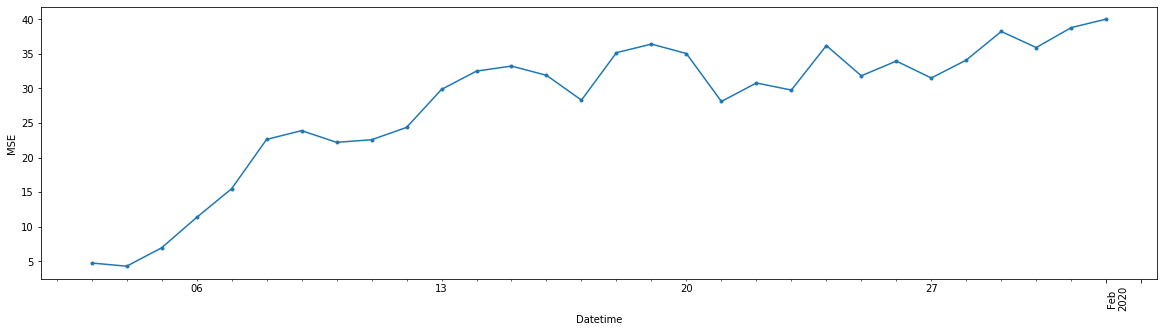

In [20]:
# Plot the mean error in function of the time.
def error_time(serie):
    date = serie.name
    pred_time = pd.DataFrame(df_prediction).transpose()[date]
    error = metrics(serie, pred_time, ERROR).compute()
    return error
    
prediction_time = test.transpose().apply(error_time)

# Show plot.
f = plt.figure(figsize = (20, 5))
prediction_time.plot(ax = f.gca(), style = ".-")
plt.ylabel(ERROR)
plt.xlabel("Datetime")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

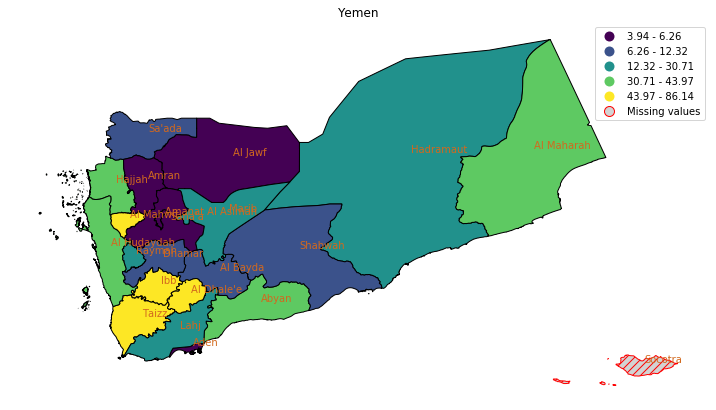

In [21]:
choropleth("Yemen", df.columns.get_level_values(0).unique(), errors, annotation = True, figsize = (15, 7))

In [22]:
# Save the results dataframe.
predictions = pd.DataFrame(df_prediction)
predictions.columns = pd.MultiIndex.from_product([predictions.columns, ["FCS"]])
predictions.columns.names = ["AdminStrata", "Indicator"]

In [23]:
test.to_csv(dir + "/test.csv")
predictions.to_csv(dir + "/kNN-TSPI.csv")